In [1]:
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from os import getcwd


# function:process_tweet()


In [2]:
# 字串處理函式

def process_tweet(tweet):

  '''
  Input:
      tweet: 一句話
  Output:
      tweets_clean: 處理過的字詞
  '''
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')
  # 使用python正規表示式套件，將字串中的特殊字元、符號、標籤及url全數抽換
  tweet = re.sub(r'\$\w*', '', tweet)
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  # 將處理過的字串進行斷句(strip_handles用以刪除推文中標記的人事物，reduce_len則是避免重複擷取推文中重複過多的字詞)
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
      if (word not in stopwords_english and word not in string.punctuation):  # 去除連接詞&標點符號
          stem_word = stemmer.stem(word)  # 將類似的字詞進行詞幹提取
          tweets_clean.append(stem_word)   # 加入tweets_clean

  return tweets_clean

# function:build_freqs()

In [3]:
# 字詞頻率計算函式

def build_freqs(result,tweets,ys):

  for y, tweet in zip(ys, tweets):
      for word in process_tweet(tweet):
          pair = (word, y) 
          if pair in result:
              result[pair] += 1 
          else:
              result[pair] = 1  
  return result


# Prepare Data

In [4]:
# 下載stopwords
nltk.download('stopwords')

# 下載tweets
nltk.download('twitter_samples')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# 切分trainning data 及 test data
train_pos = all_positive_tweets[:4000]
train_neg = all_negative_tweets[:4000]
test_pos = all_positive_tweets[4000:]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

# 製作y label
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [5]:
# 以trainning data 製作 frequency dictionary
freqs = build_freqs({},train_x,train_y)

# Define Naive_Bayes



1.   獲得標註好的資料集(pos/neg)
2.   對tweet進行預處理
3.   計算freq(w,calss)
4.   計算P(w/pos) , P(w/neg)
   *   使用laplacian smoothing處理未在訓練集中的字詞
   *   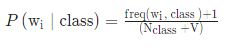

5.   計算Loglikelihood
  *   log(Dpos)-log(Dneg)   
6.   計算Logprior
  *   log[P(w/pos)/P(w/neg)]





# Define lookup()
用以查找freq中對應(word,label)的freqency


In [6]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: 你的word frequency dictionary
        word: 欲查詢的字詞
        label: 欲查詢字詞的標籤(1:pos/0:neg)
    Output:
        n: 出現頻率
    '''
    n = 0  

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [7]:
def naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: 預處理的word frequency dictionary
        train_x: X訓練集(tweets)
        train_y: Y訓練集(labels)
    Output:
        logprior: 正負向情緒資料集比率(取log)
        loglikelihood: 條件正向機率/條件負向機率 取log
    '''
    loglikelihood = {}
    logprior = 0

    # 計算freqs中的字詞數量(V)
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # 計算pos、neg的總頻率
    N_pos = N_neg= 0
    for pair in freqs.keys():        
        if pair[1] > 0:
            N_pos += freqs[pair]       
        else:
            N_neg += freqs[pair]

    # 計算pos/neg tweet數量
    # 使用filter，將序列中的元素丟進函式判斷，取出回傳True的元素，透過list組合成新的list
    # filter(函式,序列)，lambda表一匿名函式
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # 計算logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # 計算P(w|calss)
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # 計算loglikelihood
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [8]:
# 測試訓練結果
logprior, loglikelihood = naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9089


# Define predict()
p=logprior+Σlikelihood

In [9]:
def predict(tweet,logprior,loglikelihood):
  '''

  Input:
    tweet:一句話
    logprior:你的Dpos、Dneg比率(取log)
    loglikelihood:你的freq dictionary中的字詞 & 該字詞的loglikelihood
  Output:
    p:logprior+Σlikelihood

  '''

  word_l = process_tweet(tweet)
  p = 0
  p += logprior

  # 計算p
  for word in word_l:
    if word in loglikelihood:
      p += loglikelihood[word]
  
  return p

# Define score()
用以計算Naive Bayes的分數

In [10]:
def score(test_x,test_y,logprior,loglikelihood):
  acc = 0
  y_hats=[]
  for tweet in test_x:
    if predict(tweet, logprior,loglikelihood) >0:
      y_hat_i = 1
    else:
      y_hat_i = 0
    y_hats.append(y_hat_i)

  loss = np.mean(np.absolute(y_hats-test_y))
  acc = 1-loss

  return acc 

In [11]:
print(score(test_x,test_y,logprior,loglikelihood))

0.994


# 測試訓練成果

In [12]:
# 測試predict()
my_tweet = 'She is crying.'
p = predict(my_tweet,logprior,loglikelihood)
print("p=",p)
if p>0:
  print("This is postive.")
else:
  print("This is negative.")

p= -1.5787081600137383
This is negative.
